# Mixed-effects model simulation using MixedModels.jl

A recent [paper](https://psyarxiv.com/xp5cy) by DeBruin and Barr describes the use of simulations to explote the formulation and interpretation of mixed-effects models, especially in cases of crossed random-effects terms.  They use the [`lme4`](https://github.com/lme4/lme4) package for [`R`](https://R-project.org) to illustrate how the model is constructed and to perform the simulations.

`R` and `lme4` are wonderful for illustrating the concepts but not always the best for performing the simulations.  One of my purposes in creating the [`MixedModels`](https://github.com/dmbates/MixedModels.jl) package for [`Julia`](https://julialang.org) was to develop and implement data structures and algorithms that accelerate compute-intensive processes such as simulation of mixed-effects models.

The purpose of this notebook is to show how the simulations can be performed in Julia quickly and with minimal adjustment from the R representation.

## Preparing the Julia environment

Julia executables for different operating systems are available at the [download site](https://julialang.org/downloads/).  This notebook was prepared using Julia version 1.1.1 and the packages shown below.

In [1]:
using DataFrames, InteractiveUtils, LinearAlgebra, MixedModels, RData, StatsModels
versioninfo()

Julia Version 1.1.1
Commit 55e36cc308 (2019-05-16 04:10 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i5-3570 CPU @ 3.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, ivybridge)


The simulations will be based on a model defined using a formula and a data frame such as shown in Table 2 of DeBruin and Barr's paper.  The easiest way for an R user to obtain such a data frame in Julia is to create it in R, using the methods described in that paper, and save it as, say, `data.RData`, which can be read in Julia using the `RData` package.

In [2]:
dat = load("data.RData")["dat"]

,subj_id,item_id,category,RT
,String,String,String,Float64
1,S001,I01,ingroup,798.76
2,S001,I02,ingroup,800.02
3,S001,I03,ingroup,800.843
4,S001,I04,ingroup,800.143
5,S001,I05,ingroup,800.781
6,S001,I06,ingroup,799.472
7,S001,I07,ingroup,799.051
8,S001,I08,ingroup,799.584
9,S001,I09,ingroup,801.917


In [3]:
describe(dat)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,subj_id,,S001,,S100,100,,String
2,item_id,,I01,,I50,50,,String
3,category,,ingroup,,outgroup,2,,String
4,RT,799.971,796.716,799.97,803.884,,,Float64


The values of the response, `RT`, are arbitrary.  They need to be present in the data frame to construct the model but are not used in the simulation.  

## Creating a LinearMixedModel object

A mixed-effects model formula in Julia is similar to one in R but must be enclosed in a call to the `@formula` macro.  The formula for the model to be considered is

In [4]:
f1 = @formula(RT ~ 1 + category + (1+category|subj_id) + (1|item_id));

One issue to be resolved is the numerical coding of the `category` variable.  DeBruin and Barr used a $\pm0.5$ encoding. Statisticians, such as I, prefer a $\pm 1$ encoding which is generated by the "Helmert" or the "Effects" contrasts for a two-level factor.  Coding of categorical covariates is specified as a *dictionary* of key-value pairs in the call to create a `LinearMixedModel` object. Without going into too many details, the name of the column is given as a *symbol*, like `:cateegory`, and the generator for the coding as a function call, like `EffectsCoding()`.  The `=>` operator creates a key-value pair.

In [5]:
m1 = LinearMixedModel(f1, dat, Dict(:category => EffectsCoding()));

Just to check that the coding occurred as expected, the model matrix for the fixed-effects parameters is

In [6]:
m1.X

5000×2 Array{Float64,2}:
 1.0  -1.0
 1.0  -1.0
 1.0  -1.0
 1.0  -1.0
 1.0  -1.0
 1.0  -1.0
 1.0  -1.0
 1.0  -1.0
 1.0  -1.0
 1.0  -1.0
 1.0  -1.0
 1.0  -1.0
 1.0  -1.0
 ⋮        
 1.0   1.0
 1.0   1.0
 1.0   1.0
 1.0   1.0
 1.0   1.0
 1.0   1.0
 1.0   1.0
 1.0   1.0
 1.0   1.0
 1.0   1.0
 1.0   1.0
 1.0   1.0

and that for the subject-specific random effects is

In [7]:
first(m1.reterms)

5000×200 ReMat{Float64,2}:
 1.0  -1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  -1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  -1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  -1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  -1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  -1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  -1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  -1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  -1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  -1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  -1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  -1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  -1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮         

(If you are concerned about the size of this matrix, don't worry - it is stored in a much more compact way.)

### Specifying parameter values

The fixed-effects parameter vector in DeBruine and Barr's formula is `[800.0, 50.0]` for the $\pm 0.5$ coding, which corresponds to `[800.0, 25.0]` in the $\pm 1$ coding.  It is written as $\beta$. The standard deviation for the residual, written $\sigma$, is `200.0`.

In [8]:
β = [800.0; 25.0]

2-element Array{Float64,1}:
 800.0
  25.0

In [9]:
σ = 200.0

200.0

The standard deviation of the by-subject intercept random-effects is `100.0` and the by-item intercept random-effects is `80.0`.  The standard deviation of the by-subject slope random effects is `40.0` in the $\pm0.5$ coding or `20.0` in the $\pm 1$ coding.  The within-subject correlation is `0.2`.

Internally both the `lme4` and the `MixedModels` package use parameters derived from the *relative covariance factor* of the random effects distribution. In this case the correlation matrix for the random effects by subject is

In [10]:
cormat = [1. 0.2; 0.2 1.]

2×2 Array{Float64,2}:
 1.0  0.2
 0.2  1.0

Combining this with the standard deviations produces the covariance matrix

In [11]:
covmat = Diagonal([100. 20.]) * cormat * Diagonal([100. 20.])

2×2 Array{Float64,2}:
 10000.0   2000.0
  2000.0  10000.0

The covariance factor is the lower Cholesky factor of this positive definite symmetric matrix

In [12]:
covfac = cholesky(covmat).L

2×2 LowerTriangular{Float64,Array{Float64,2}}:
 100.0    ⋅    
  20.0  97.9796

The relative covariance factor is `covfac/σ`

In [13]:
Λ = covfac ./ σ

2×2 LowerTriangular{Float64,Array{Float64,2}}:
 0.5   ⋅      
 0.1  0.489898

leading to a covariance parameter vector for the subject-specific random effects of

In [14]:
θ = Λ[[1,2,4]]

3-element Array{Float64,1}:
 0.5               
 0.1               
 0.4898979485566356

For the item-specific random effects the relative covariance factor is simply the ratio of the standard deviation of the intercepts to σ.  This is appended to the current 

In [15]:
push!(θ, 80.0/200.0)

4-element Array{Float64,1}:
 0.5               
 0.1               
 0.4898979485566356
 0.4               

Simulation of a response vector and fitting the model to that vector is performed as

In [16]:
refit!(simulate!(m1, β=β, σ=σ, θ=θ))

Linear mixed model fit by maximum likelihood
 RT ~ 1 + category + (1 + category | subj_id) + (1 | item_id)
     logLik        -2 logLik          AIC             BIC       
 -3.39266435×10⁴   6.7853287×10⁴   6.7867287×10⁴  6.79129074×10⁴

Variance components:
                 Column        Variance   Std.Dev.    Corr.
 subj_id  (Intercept)         11338.9596 106.484551
          category: outgroup   9815.9139  99.075294  0.25
 item_id  (Intercept)          6659.6092  81.606429
 Residual                     40136.6126 200.341241
 Number of obs: 5000; levels of grouping factors: 100, 50

  Fixed-effects parameters:
──────────────────────────────────────────────────────────
                    Estimate  Std.Error   z value  P(>|z|)
──────────────────────────────────────────────────────────
(Intercept)         806.724     15.9565  50.5578    <1e-99
category: outgroup   49.5928    15.4719   3.20535   0.0013
──────────────────────────────────────────────────────────

A Julia convention is to append `!` to the names of *mutating* functions, which can change the value of one or more of the functions arguments.  Typically it is the first argument that is changed.  That is, the call to `push!` modifies `θ` and the call to `simulate!` modifies and returns `m1` which is then further modified by the call to `refit!`.

## Simulating the distribution of an estimator

The focus of this simulation is the estimate of the effect of category.

In [17]:
last(m1.β)

49.592769202791125

and its standard error

In [18]:
last(m1.stderror)

15.471866250816344

It is useful to create a function to perform the simulation and store the values in a `DataFrame`.

In [19]:
function lmmSim(N, m, β, σ, θ)
    b = similar(β, N)
    se = similar(b)
    for i in 1:N
        refit!(simulate!(m, β=β, σ=σ, θ=θ))
        b[i] = last(m.β)
        se[i] = last(m.stderror)
    end
    DataFrame(estimate=b, stderr=se)
end

lmmSim (generic function with 1 method)

Just to check that it works as expected

In [20]:
lmmSim(10, m1, β, σ, θ)

,estimate,stderr
,Float64,Float64
1,22.122,13.084
2,47.4013,15.5551
3,45.4024,14.1161
4,23.06,14.2855
5,0.280425,16.06
6,17.7822,15.6946
7,19.4438,13.2523
8,-4.89727,16.6772
9,19.4918,13.4021


Now collect a larger sample

In [21]:
sim = @time lmmSim(10000, m1, β, σ, θ);

263.108074 seconds (630.32 M allocations: 32.091 GiB, 1.24% gc time)


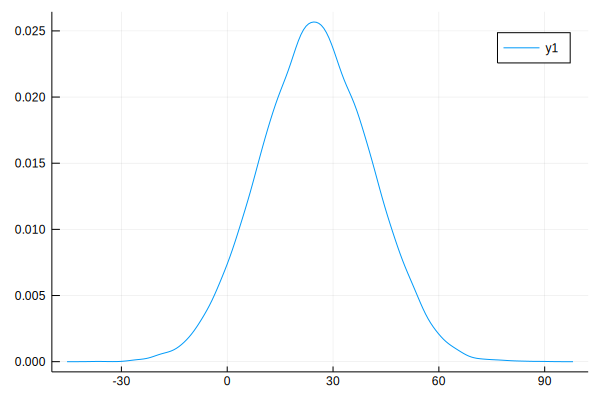

In [22]:
using StatsPlots
@df sim density(:estimate)

In [23]:
describe(sim)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Nothing,DataType
1,estimate,24.9663,-36.5008,24.9127,89.1207,,,Float64
2,stderr,15.1986,11.5876,15.1827,19.0029,,,Float64


An empirical p-value for the one-sided test of $H_0:\beta_1\le0$ versus $H_a:\beta_1>0$ is

In [24]:
sum(x ≤ 0 for x in sim.estimate)/length(sim.estimate)

0.0555